In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from hardwares.hardware_params import hardware_params
from model_analyzer import ModelAnalyzer

/home/shen/miniconda3/envs/3dsim/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# model_id="meta-llama/Llama-2-13b-hf"
# hardware="nvidia_A6000"
model_id="Qwen/Qwen2.5-7B"
hardware="Samsung_Exynos_2400"
analyzer=ModelAnalyzer(model_id,hardware)

use config file configs/Qwen.py for Qwen/Qwen2.5-7B


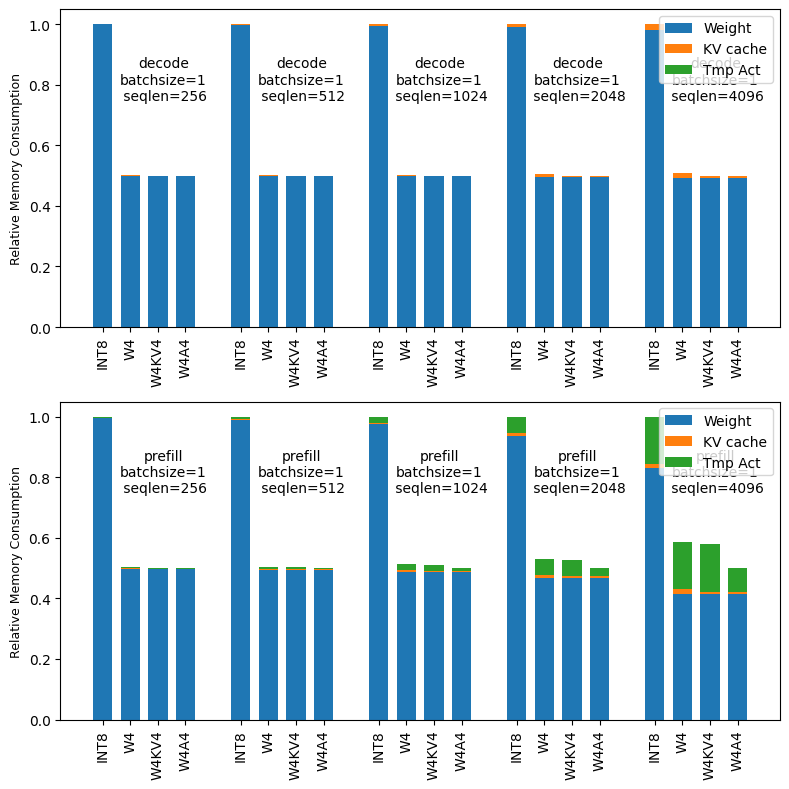

In [5]:
# Quantization

fig=plt.figure(figsize=(8, 8))
bar_width = 0.7

for step in ['decode','prefill']:
    plt.subplot(2, 1, 1 if step=='decode' else 2)
    weights=[]
    kvs=[]
    tmp_acts=[]
    categories=[]
    annotation_xs=[]
    annotation_texts=[]
    xs=[]
    x_st=0
    # for batchsize,seqlen in [(1,1024),(1,4096),(16,1024)]:
    for batchsize,seqlen in [(1,256),(1,512),(1,1024),(1,2048),(1,4096)]:
        # FP16_sum=0
        INT8_sum=0
        annotation_xs.append(x_st)
        annotation_texts.append(f"{step}\nbatchsize={batchsize}\n seqlen={seqlen}")
        # for w,a,kv,quantization in [(16,16,16,"FP16"),(4,16,16,"W4"),(4,16,4,"W4KV4"),(4,4,4,"W4A4")]:
        for w,a,kv,quantization in [(8,8,8,"INT8"),(4,8,8,"W4"),(4,8,4,"W4KV4"),(4,4,4,"W4A4")]:
            # print(f"batchsize={batchsize}, seqlen={seqlen}, w={w}, a={a}, kv={kv}")
            result=analyzer.analyze(seqlen,batchsize,w,a,kv)
            weights.append(result["total_results"][step]["memory_consumption_weight"])
            kvs.append(result["total_results"][step]["memory_consumption_kv_cache"])
            tmp_acts.append(result["total_results"][step]["memory_consumption_tmp_act"])
            xs.append(x_st)
            x_st+=1
            categories.append(f"{quantization}")
            # if quantization=="FP16":
                # FP16_sum=weights[-1]+kvs[-1]+tmp_acts[-1]
            if quantization=="INT8":
                INT8_sum=weights[-1]+kvs[-1]+tmp_acts[-1]
            # weights[-1]/=FP16_sum
            # kvs[-1]/=FP16_sum
            # tmp_acts[-1]/=FP16_sum
            weights[-1]/=INT8_sum
            kvs[-1]/=INT8_sum
            tmp_acts[-1]/=INT8_sum
        x_st+=1
    plt.bar(xs, weights, bar_width, label='Weight')
    plt.bar(xs, kvs, bar_width, bottom=weights, label='KV cache')
    plt.bar(xs, tmp_acts, bar_width, bottom=np.array(kvs) + np.array(weights), label='Tmp Act')

    for ann_x,ann_text in zip(annotation_xs,annotation_texts):
        plt.annotate(ann_text, (ann_x+2.2, 0.75), ha='center')
    plt.ylabel('Relative Memory Consumption', fontsize=9)
    plt.xticks(xs, categories, rotation=90)
    plt.legend()
    plt.tight_layout()
plt.savefig("../output/quantization_memory_consumption.pdf",bbox_inches='tight')